In [1]:
import numpy as np
import cv2
from os import listdir
import matplotlib.pyplot as plt
from keras import layers, losses, metrics, optimizers
from keras.models import Model
import tensorflow as tf

2023-05-11 23:08:13.911733: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-11 23:08:14.013391: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-11 23:08:14.014108: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-11 23:08:14.716960: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
custom_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='acc',
    patience=8,
    min_delta=0.001,
    mode='max'
)

In [3]:
def load_data_from_folder(images_dir, height, width, depth):
    dir_names = listdir(images_dir)
    dir_count = len(dir_names)
    images_real = {}
    images_forgery = {}
    labels = set()
    for dir_name in dir_names:
        parts = dir_name.split('_')
        label_text = parts[0]
        is_forgery = len(parts) > 1
        if (label_text not in labels):
            labels.add(label_text)
        if label_text not in images_real:
            images_real[label_text] = []
        if label_text not in images_forgery:
            images_forgery[label_text] = []
        image_file_names = listdir(images_dir + '/' + dir_name)
        for image_file_name in image_file_names:
            image = cv2.imread(images_dir + '/' + dir_name + '/' + image_file_name, cv2.IMREAD_GRAYSCALE)
            if is_forgery:
                images_forgery[label_text].append(image)
            else:
                images_real[label_text].append(image)
    X_base_list = []
    X_comparison_list = []
    y_list = []
    for label in labels:
        real_samples = images_real[label]
        forged_samples = images_forgery[label]
        for real_img in real_samples:
            real_resized = cv2.resize(real_img, (width, height))
            for another_real in real_samples:
                another_resized = cv2.resize(another_real, (width, height))
                X_base_list.append(real_resized.reshape((width, height, depth)))
                X_comparison_list.append(another_resized.reshape((width, height, depth)))
                y_list.append(1)
                for another_fake in forged_samples:
                    fake_resized = cv2.resize(another_fake, (width, height))
                    X_base_list.append(real_resized.reshape((width, height, depth)))
                    X_comparison_list.append(fake_resized.reshape((width, height, depth)))
                    y_list.append(0)
    X_base = np.array(X_base_list)
    X_comparison = np.array(X_comparison_list)
    y = np.array(y_list)
    return X_base, X_comparison, y

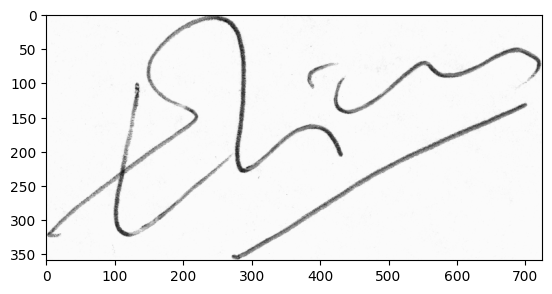

In [4]:
images_dir = 'data2/sign_data/train/001'
depth = 1
file_names = listdir(images_dir)
first_image = cv2.imread(images_dir + '/' + file_names[0], cv2.IMREAD_GRAYSCALE)
plt.imshow(first_image, cmap='gray')
height, width = first_image.shape
plt.show()

In [5]:
width = 130
height = 130

In [ ]:
%%time
X_base, X_comparison, y = load_data_from_folder('data2/sign_data/train', height, width, depth)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

In [1]:
index = 3
f, axes = plt.subplots(1,2)
axes[0].imshow(X_base[index, :, :, 0], cmap='gray')
axes[1].imshow(X_comparison[index, :, :, 0], cmap='gray')
plt.show()

NameError: name 'X_base' is not defined

In [ ]:
x1 = layers.Input(shape=(height, width, depth))
x2 = layers.Input(shape=(height, width, depth))

In [ ]:
# параллельная модель
inputs = layers.Input(shape=(height, width, depth))
feature = layers.Conv2D(2, 3, activation='relu')(inputs)
feature = layers.MaxPooling2D(2)(feature)
feature = layers.Conv2D(4, 3, activation='relu')(feature)
feature = layers.MaxPooling2D(2)(feature)
feature = layers.Conv2D(8, 3, activation='relu')(feature)
feature = layers.MaxPooling2D(2)(feature)
feature_model = Model(inputs=inputs, outputs=feature)
x1_net = feature_model(x1)
x2_net = feature_model(x2)
net = layers.Subtract()([x1_net, x2_net])
net = layers.Conv2D(8, 3, activation='relu')(net)
net = layers.MaxPooling2D(2)(net)
net = layers.Flatten()(net)
net = layers.Dense(8, activation='relu')(net)
net = layers.Dense(1, activation='sigmoid')(net)

In [ ]:
%%time
classifier = Model(inputs=[x1, x2], outputs=net)
classifier.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
classifier.summary()

In [ ]:
%%time
classifier.fit([X_base, X_comparison], y, verbose = 1, batch_size=32, epochs = 1)

In [ ]:
%%time
X_base_my, X_comparison_my, y_my = load_data_from_folder('data2/sign_data/my', height, width, depth)

In [ ]:
%%time
my_predict = classifier.predict([X_base_my, X_comparison_my])
print(y_my)
print(my_predict)